This notebook explores the effect of adding a LSTM layer to the CNN network in 'Neil_CNN.ipynb'

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from tqdm import tqdm

In [25]:
training_df = pd.read_csv('data/training_set.csv')
training_metadata_df = pd.read_csv('data/training_set_metadata.csv')

In [26]:
training_metadata_df.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [4]:
objs = np.unique(training_df.object_id)
passbands = [0, 1, 2, 3, 4, 5]
targets = np.unique(training_metadata_df.target)

# Normalize and interpolate time series

In [204]:
#training_df_new = pd.DataFrame({'object_id' : np.array([], dtype=int), 'flux' : []})
X = []
y = []
for obj in tqdm(objs):
    data = training_df[training_df.object_id == obj]
    #mean_mjd = np.mean(data.mjd)
    #std_mjd = np.std(data.mjd)
    min_mjd = np.min(data.mjd)
    max_mjd = np.max(data.mjd)
    #mean_flux = np.mean(data.flux)
    #std_flux = np.std(data.flux)
    min_flux = np.min(data.flux)
    max_flux = np.max(data.flux)
    flux_all = []
    for passband in passbands:
        #data = training_df[training_df.object_id == obj][training_df.passband == passband]
        data = training_df.loc[(training_df.object_id == obj) & (training_df.passband == passband)]
        norm_mjd = (data.mjd - min_mjd)/(max_mjd - min_mjd)
        norm_flux = (data.flux - min_flux)/(max_flux - min_flux)
        mjd_interp = np.linspace(np.min(norm_mjd), np.max(norm_mjd), 100)
        interp = interp1d(norm_mjd, norm_flux, kind='linear')
        flux_interp = interp(mjd_interp)
        flux_all += [flux_interp]
    X += [flux_all]
    y += [1.*(targets == int(training_metadata_df.loc[training_metadata_df.object_id == obj].target))]
    #df = pd.DataFrame(data={'object_id' : np.tile([obj], 6*len(mjd_interp)), 'flux' : flux_all})
    #training_df_new = training_df_new.append(df, ignore_index=True)

100%|██████████| 7848/7848 [07:08<00:00, 18.31it/s]


# Deep Learning

In [10]:
import keras
import tensorflow as tf
import seaborn as sn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [11]:
N = []
for i in np.arange(len(targets)):
    N += [len(training_metadata_df.loc[training_metadata_df.target == targets[i]])]
w = N/np.sum(N)
print(targets)
print(w)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]
[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]


In [12]:
def LogLoss(y_true, y_pred):
    y_clip = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    loss = -(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(y_clip), axis=0)/w))
    return loss

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
num_classes = len(targets)

In [1]:
n_out = 14

In [33]:
activation = 'relu'
dropout_rate = 0.5
CNN_model = Sequential()
CNN_model.add(Reshape((6, 1000, 1), input_shape=(6,1000)))

CNN_model.add(Conv2D(8, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(16, kernel_size=(2, 5), activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Conv2D(32, kernel_size=(3, 5), activation=activation))
#CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(dropout_rate))
keras.layers.LSTM(n_out)

CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation=activation))
CNN_model.add(Dropout(dropout_rate))
CNN_model.add(Dense(32, activation=activation))
CNN_model.add(Dropout(dropout_rate))

CNN_model.add(Dense(num_classes, activation='softmax'))
print(CNN_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 6, 1000, 1)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 996, 8)         88        
_________________________________________________________________
dropout_26 (Dropout)         (None, 5, 996, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 992, 16)        1296      
_________________________________________________________________
dropout_27 (Dropout)         (None, 4, 992, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 988, 32)        7712      
_________________________________________________________________
dropout_28 (Dropout)         (None, 2, 988, 32)        0         
__________

In [34]:
CNN_model.compile(loss=LogLoss,
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
epochs = 300
batch_size = 100
CNN_history = CNN_model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            shuffle=True,
                            validation_data=(X_test, y_test))

Train on 5862 samples, validate on 1466 samples
Epoch 1/300
5862/5862 [==============================] - 92s 16ms/step - loss: 2.6302 - acc: 0.0902 - val_loss: 2.6334 - val_acc: 0.0498
Epoch 2/300
5862/5862 [==============================] - 87s 15ms/step - loss: 2.5558 - acc: 0.1058 - val_loss: 2.6081 - val_acc: 0.0546
Epoch 3/300
5862/5862 [==============================] - 88s 15ms/step - loss: 2.4941 - acc: 0.1298 - val_loss: 2.4883 - val_acc: 0.0668
Epoch 4/300
5862/5862 [==============================] - 96s 16ms/step - loss: 2.4207 - acc: 0.1627 - val_loss: 2.4655 - val_acc: 0.2019
Epoch 5/300
5862/5862 [==============================] - 97s 17ms/step - loss: 2.3715 - acc: 0.1986 - val_loss: 2.4189 - val_acc: 0.1453
Epoch 6/300
5862/5862 [==============================] - 87s 15ms/step - loss: 2.3228 - acc: 0.2045 - val_loss: 2.3493 - val_acc: 0.1930
Epoch 7/300
5862/5862 [==============================] - 87s 15ms/step - loss: 2.2892 - acc: 0.2257 - val_loss: 2.2853 - val_acc: 

5862/5862 [==============================] - 88s 15ms/step - loss: 1.0436 - acc: 0.4565 - val_loss: 2.3163 - val_acc: 0.3813
Epoch 61/300
5862/5862 [==============================] - 88s 15ms/step - loss: 1.0345 - acc: 0.4531 - val_loss: 2.4233 - val_acc: 0.4318
Epoch 62/300
5862/5862 [==============================] - 88s 15ms/step - loss: 1.0678 - acc: 0.4584 - val_loss: 2.3420 - val_acc: 0.4065
Epoch 63/300
5862/5862 [==============================] - 88s 15ms/step - loss: 1.0312 - acc: 0.4623 - val_loss: 2.2424 - val_acc: 0.3977
Epoch 64/300
5862/5862 [==============================] - 88s 15ms/step - loss: 1.0662 - acc: 0.4592 - val_loss: 2.1815 - val_acc: 0.3799
Epoch 65/300
5862/5862 [==============================] - 89s 15ms/step - loss: 1.0035 - acc: 0.4664 - val_loss: 2.3228 - val_acc: 0.4038
Epoch 66/300
5862/5862 [==============================] - 88s 15ms/step - loss: 1.0211 - acc: 0.4642 - val_loss: 2.3221 - val_acc: 0.3874
Epoch 67/300
5862/5862 [=======================

5862/5862 [==============================] - 91s 16ms/step - loss: 0.6152 - acc: 0.6438 - val_loss: 4.0162 - val_acc: 0.4870
Epoch 179/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.5941 - acc: 0.6426 - val_loss: 4.2505 - val_acc: 0.4993
Epoch 180/300
5862/5862 [==============================] - 87s 15ms/step - loss: 0.5649 - acc: 0.6602 - val_loss: 4.0947 - val_acc: 0.4959
Epoch 181/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.6666 - acc: 0.6358 - val_loss: 3.8198 - val_acc: 0.4611
Epoch 182/300
5862/5862 [==============================] - 89s 15ms/step - loss: 0.6260 - acc: 0.6163 - val_loss: 4.6737 - val_acc: 0.4775
Epoch 183/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.6879 - acc: 0.6317 - val_loss: 4.1283 - val_acc: 0.4468
Epoch 184/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.6410 - acc: 0.6249 - val_loss: 4.1625 - val_acc: 0.4761
Epoch 185/300
5862/5862 [================

5862/5862 [==============================] - 88s 15ms/step - loss: 0.4804 - acc: 0.7039 - val_loss: 4.2891 - val_acc: 0.5089
Epoch 238/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4764 - acc: 0.7057 - val_loss: 4.0910 - val_acc: 0.4952
Epoch 239/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4881 - acc: 0.6974 - val_loss: 4.3625 - val_acc: 0.4925
Epoch 240/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4672 - acc: 0.7037 - val_loss: 4.2017 - val_acc: 0.4850
Epoch 241/300
5862/5862 [==============================] - 87s 15ms/step - loss: 0.4838 - acc: 0.6907 - val_loss: 4.6763 - val_acc: 0.4884
Epoch 242/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4996 - acc: 0.7033 - val_loss: 4.6687 - val_acc: 0.4843
Epoch 243/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.5070 - acc: 0.7079 - val_loss: 4.7628 - val_acc: 0.5041
Epoch 244/300
5862/5862 [================

5862/5862 [==============================] - 88s 15ms/step - loss: 0.4351 - acc: 0.7279 - val_loss: 4.7214 - val_acc: 0.5246
Epoch 297/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4374 - acc: 0.7351 - val_loss: 5.0231 - val_acc: 0.4966
Epoch 298/300
5862/5862 [==============================] - 87s 15ms/step - loss: 0.4264 - acc: 0.7443 - val_loss: 4.3358 - val_acc: 0.5000
Epoch 299/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4294 - acc: 0.7359 - val_loss: 5.0381 - val_acc: 0.5205
Epoch 300/300
5862/5862 [==============================] - 88s 15ms/step - loss: 0.4460 - acc: 0.7448 - val_loss: 4.6097 - val_acc: 0.5061


In [50]:
np.min(np.array(CNN_history.history['val_loss']))

1.8606039861377233

minimum validtion loss is 1.86

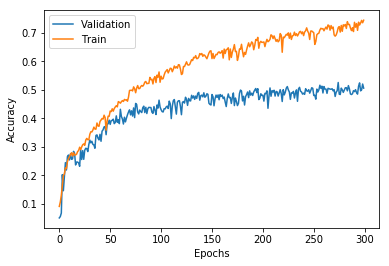

In [46]:
plt.plot(CNN_history.history['val_acc'], label='Validation')
plt.plot(CNN_history.history['acc'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('CNN_acc_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

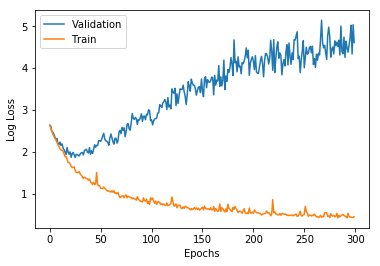

In [44]:
plt.plot(CNN_history.history['val_loss'], label='Validation')
plt.plot(CNN_history.history['loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig('CNN_loss_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()

Something strange is going in the figure above. Just after 25 - 30 epochs, the validation loss sharply rises. It could be that addding the LSTM layer causes overfitting?

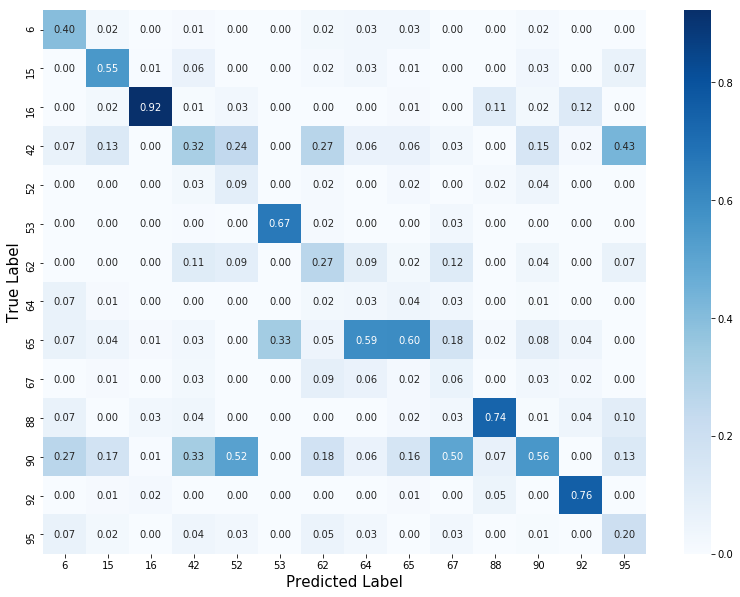

In [45]:
test_pred = CNN_model.predict(X_test)
CNN_cf = confusion_matrix(y_test.argmax(axis=1), test_pred.argmax(axis=1))
CNN_cf_norm = CNN_cf / CNN_cf.sum(axis=0)

plt.figure(figsize = (13.5,10))
sn.heatmap(CNN_cf_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=targets, yticklabels=targets)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.savefig('CNN_confusion_matrix_500_epochs.png', dpi=200, bbox_inches='tight')
plt.show()